## TOY PROJECT 03 - 카메라 스티커 앱 만들기
셀카 이미지에 고양이 수염 스티커를 붙이는 프로그램을 작성하고자 합니다.  
고양이 수염이 위치할 곳을 찾아내는 것이 관건인데, 안면인식 알고리즘을 활용해 이를 해결합니다.

<details>
<summary>KEYWORDS</summary>
<div>
Keypoint Detection<br>  
HOG(Histogram of Oriented Graphics)<br>    
SVM(Support Vector Machine)<br>    
image pyramid<br>    
face landmark localization<br>    
object keypoint estimation<br>  
</div>
</details>



목차

1. 라이브러리 불러오기
2. 얼굴 인식
3. 스티커 위치 선정 및 부착

### 1. 라이브러리 불러오기
이미지를 호출과 처리를 위해 `cv2`, 안면인식 및 전처리를 위해 `dlib`, 시각화를 위해 `matplotlib`을 사용합니다.  
이미지를 벡터로 다루기 때문에 `numpy`를 호출해 필요시 활용합니다.


In [2]:
import numpy as np

import cv2
import dlib
import matplotlib.pyplot as plt


### 2. 얼굴 인식

#### 2.1. 셀프 카메라 이미지 호출


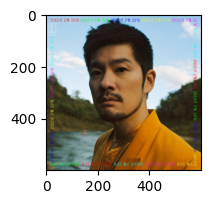

In [3]:
selfie_path = 'data/Camera_Sticker/giha_jang.jpg'

img_bgr = cv2.imread(selfie_path) # 이미지를 호출하고
img_copy = img_bgr.copy() # 전처리를 위해 깊은 복사를 수행합니다
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # 이미지 색상 배열을 rgb로 변경합니다

plt.figure(figsize=(2,3))
plt.imshow(img_rgb)
plt.show()


#### 2.2. 얼굴 인식 박스
`dlib` 라이브러리의 `get_frontal_face_detector()`로 얼굴 전(前)면을 인식합니다.  
HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine) 방식을 활용, 색상의 변화를 감지해 얼굴이 있는 영역을 찾아냅니다.

<details>
<summary>HOG(Histogram of Oriented Gradients)란?</summary>
<div>
</div>
</details>

<details>
<summary>SVM(Support Vector Machine)이란?</summary>
<div>
</div>
</details>

In [4]:
detector_hog = dlib.get_frontal_face_detector() # face detector()를 변수에 배정

dlib_rects = detector_hog(img_rgb, 1) 
dlib_rects 


rectangles[[(142, 142) (365, 365)]]

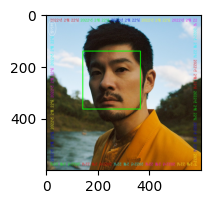

In [5]:
for dlib_rect in dlib_rects: # 탐지한 얼굴 영역의 네 좌표
    
    l = dlib_rect.left()  # 왼쪽 아래 점의 x좌표
    t = dlib_rect.top()  # 왼쪽 위 점의 y좌표
    r = dlib_rect.right()  # 오른쪽 아래 점의 x좌표
    b = dlib_rect.bottom()  # 아래쪽 위 점의 y좌표
    
    cv2.rectangle(img_rgb, (l, t), (r, b), (0, 255, 0), 2, # (0, 255, 0) - 초록 선
                    lineType=cv2.LINE_AA)  # 시작점의 좌표와 종료점 좌표로 직각 사각형 그리기

plt.figure(figsize=(2,3))
plt.imshow(img_rgb)
plt.show()


#### 2.3. 얼굴 부위 랜드마크

In [6]:
model_path = '../EXPLORATIONS/data/03/models/shape_predictor_68_face_landmarks.dat' 
landmark_predictor = dlib.shape_predictor(model_path) # 랜드마크 예측 모델을 `landmark_pred` 변수로 정의합니다


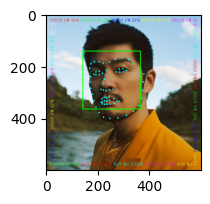

In [7]:
model_path = '../EXPLORATIONS/data/03/models/shape_predictor_68_face_landmarks.dat' 
landmark_predictor = dlib.shape_predictor(model_path) # 랜드마크 예측 모델을 `landmark_pred` 변수로 정의합니다


list_landmarks = []

'''shape_predictor = RGB 이미지와 dlib 사각형을 입력받습니다'''
for dlib_rect in dlib_rects: # 인식한 얼굴이 하나이므로 dlib_rects의 원소 개수도 하나입니다
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_rgb, point, 3, (0, 255, 255), -1)

plt.figure(figsize=(2,3))
plt.imshow(img_rgb) # 이미지를 준비
plt.show() # 이미지를 출력
    

### 3. 스티커 위치 선정

먼저, 고양이 수염 스티커를 불러옵니다.  
얼굴에 적용될 스티커의 크기를 인식된 얼굴 크기로 맞춰줍니다.


(512, 512, 3)


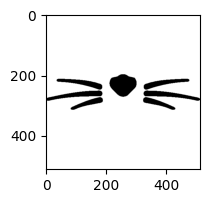

In [8]:
whisker_path = 'data/Camera_Sticker/cat_whiskers.png'
sticker = cv2.imread(whisker_path)

print(sticker.shape)
plt.figure(figsize=(2,2))
plt.imshow(sticker)
plt.show()


In [9]:
face_area = (dlib_rect.width(), dlib_rect.width())
sticker = cv2.resize(sticker, face_area)


#### 3.1. 첫번째 시도 - 코 중앙 위치에 붙이기

In [10]:
num_lm = 30 # 코의 index=30

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[num_lm][0] 
    y = landmark[num_lm][1] 
    w = h = dlib_rect.width()
    
    print (f'(x,y) : ({x},{y})') # 코 중앙 landmark의 좌표
    print (f'(w,h) : ({w},{h})') # 얼굴 영역 직사각형의 너비&높이


(x,y) : (222,268)
(w,h) : (224,224)


(224, 224, 3)


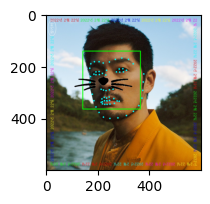

In [11]:
refined_x = x - (w // 2)
refined_y = y - (h // 2)

sticker_area = img_rgb[refined_y:refined_y+sticker.shape[0], refined_x:refined_x+sticker.shape[1]]
print(sticker_area.shape)

img_rgb[refined_y:refined_y+sticker.shape[0], refined_x:refined_x+sticker.shape[1]] = \
    np.where(sticker==255, sticker_area, sticker).astype(np.uint8)

plt.figure(figsize=(2,3))
plt.imshow(img_rgb)
plt.show()

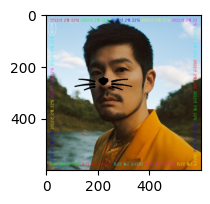

In [12]:
sticker_area = img_copy[refined_y:refined_y+sticker.shape[0], refined_x:refined_x+sticker.shape[1]]

img_copy[refined_y:refined_y+sticker.shape[0], refined_x:refined_x+sticker.shape[1]] = \
    np.where(sticker==255,sticker_area,sticker).astype(np.uint8)

plt.figure(figsize=(2,3))
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))

plt.show()

#### 3.2. 함수화
지금까지의 과정을 함수화합니다. 셀카 사진과 스티커 사진을 입력해 둘이 합성된 사진을 출력하는 기능을 구현하려 하니,  
input이 `사진 path`와 `스티커 사진 path`, output이 `합성된 스티커 사진`이 되도록 직관적으로 설계합니다.


In [7]:
selfie_path = "data/Camera_Sticker/selfie.jpg"
sticker_path = "data/Camera_Sticker/cat_whiskers.png"


In [16]:
def get_converted_img(img_path):
    import cv2
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb
    

In [1]:
def get_face_rect_n_landmarks(image):
    import os
    import dlib
    
    model_path = os.getcwd() + f"..\\EXPLORATIONS\\data\\Camera_Sticker\\shape_predictor.dat"
    
    def get_face_rects(img):
        face_detector = dlib.get_frontal_face_detector()
        face_rects = face_detector(img, 1)
        
        return face_rects       
    
    def get_face_landmarks(img, face_rects, model_path):
        landmark_predictor = dlib.shape_predictor(model_path)
        
        face_landmarks = []
        
        for face_rect in face_rects: 
            points = landmark_predictor(img, face_rect)
            list_points = list(map(lambda p: (p.x, p.y), points.parts()))
            face_landmarks.append(list_points)

        return face_landmarks    

    rects = get_face_rects(image)
    landmarks = get_face_landmarks(image, rects, model_path)
    
    return rects, landmarks

In [ ]:
def attatch_sticker(img, sticker_path, rects, landmarks):
    # 속성
    face_area = (rects.width(), rects.height())
    sticker_starting_point = 
    
    sticker = get_converted_img(sticker_path)
    sticker = sticker.resize()
    

In [17]:
img_selfie = get_converted_img(selfie_path)
rects, landmarks = get_face_rect_n_landmarks(img_selfie)


2

In [37]:
def camera_sticker(selfie_path, sticker_path):
    import cv2
    import matplotlib.pyplot as plt
    
    def get_converted_img(img_path):
        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        return img_rgb
    
    img_selfie = get_converted_img(selfie_path)
    img_selfie_copy = img_selfie.copy()
    img_sticker = get_converted_img(sticker_path)
    
    
    
    return selfie_with_sticker



(494, 849, 555, 555)

### 4. 발생 가능한 문제 탐색하기 (To Be Added)

(1) 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.  

(2) 문제점이 무엇인지 최대한 자세하게 기록해 보세요. 여러분이 생각한 문제점을 해결하기 위한 방법은 분명 존재합니다!  

오늘 만든 스티커앱에서 생각해볼 수 있는 문제점은 다음과 같습니다.  

- 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
얼굴 각도에 따라 

- 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
사진은 2차원, 실물은 3차원. 실물이 존재하는 x, y, z축을 기준으로 

- 실행 속도가 중요할까요?


- 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

